# importing the Libraries 

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint
from sklearn.preprocessing import PolynomialFeatures

# Importing the data and Data Wrangling

In [4]:
bike_master = pd.read_csv('bike_full.csv', dtype={5: str, 7: str})  # Convert both columns to strings


# Data Cleaning

In [6]:
bike_master_clean = bike_master.copy()

# Convert datetime columns
bike_master_clean['started_at'] = pd.to_datetime(bike_master_clean['started_at'])
bike_master_clean['ended_at'] = pd.to_datetime(bike_master_clean['ended_at'])

# Convert category columns
category_columns = ['rideable_type', 'start_station_name', 'end_station_name', 'member_casual']
for col in category_columns:
    bike_master_clean[col] = bike_master_clean[col].astype('category')

# Convert string columns (IDs)
string_columns = ['ride_id', 'start_station_id', 'end_station_id']
for col in string_columns:
    bike_master_clean[col] = bike_master_clean[col].astype('string')

In [7]:
#finding unique values for few columns
bike_master_clean[['start_station_name', 'end_station_name', 'start_station_id', 'end_station_id','start_lat']].nunique()

start_station_name       860
end_station_name         865
start_station_id        1321
end_station_id          1338
start_lat             570110
dtype: int64

In [8]:
#create a new column for month year
bike_master_clean['month_year'] = bike_master_clean['started_at'].dt.to_period('M')

#create a new column for year
bike_master_clean['year'] = bike_master_clean['started_at'].dt.year

#create a new dataframe for the month june 2023 to december 2023
bike_master_clean_2023 = bike_master_clean[(bike_master_clean['year'] == 2023)]

row_count = len(bike_master_clean_2023)
print(f"Number of rows in the dataset: {row_count}")

Number of rows in the dataset: 4467334


In [10]:
# Function to categorize stations
def categorize_station_location(lat, lng):
    regions = {
        'Washington DC': {'lat': (38.8, 39.0), 'lng': (-77.12, -76.9)},
        'Arlington': {'lat': (38.8, 38.93), 'lng': (-77.17, -77.03)},
        'Alexandria': {'lat': (38.77, 38.85), 'lng': (-77.15, -77.03)},
        'Montgomery County': {'lat': (38.95, 39.2), 'lng': (-77.3, -76.9)},
        "Prince George's County": {'lat': (38.8, 39.1), 'lng': (-76.95, -76.7)},
        'Fairfax County': {'lat': (38.7, 39.0), 'lng': (-77.4, -77.15)}
    }
    
    for region, bounds in regions.items():
        if (bounds['lat'][0] <= lat <= bounds['lat'][1] and 
            bounds['lng'][0] <= lng <= bounds['lng'][1]):
            return region
    return 'Other'

# Apply function to classify each start station
bike_master_clean_2023.loc[:, 'region'] = bike_master_clean_2023.apply(
    lambda row: categorize_station_location(row['start_lat'], row['start_lng']),
    axis=1
)

In [15]:
#convert the region column to category
bike_master_clean_2023['region'] = bike_master_clean_2023['region'].astype('category')

# EDA and Plotting 

In [16]:
#find missing null values
print(bike_master_clean_2023.isnull().sum())

#drop missing values
bike_master_clean_2023 = bike_master_clean_2023.dropna()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
month_year            0
year                  0
region                0
dtype: int64


In [17]:
bike_master_clean_2023.isnull().sum()
bike_master_clean_2023.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3864783 entries, 6226664 to 10693995
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       category      
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  category      
 5   start_station_id    string        
 6   end_station_name    category      
 7   end_station_id      string        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       category      
 13  month_year          period[M]     
 14  year                int32         
 15  region              category      
dtypes: category(5), datetime64[ns](2), float64(4), int32(1), period[M](1), string(3)
memory usage: 365.0 MB


In [23]:
# Data Aggregation
bike_master_clean_2023['ride_duration'] = (bike_master_clean_2023['ended_at'] - bike_master_clean_2023['started_at']).dt.total_seconds() / 60  # duration in minutes
bike_master_clean_2023['day_of_week'] = bike_master_clean_2023['started_at'].dt.dayofweek
bike_master_clean_2023['is_weekend'] = bike_master_clean_2023['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Calculating station popularity
start_station_popularity = bike_master_clean_2023.groupby('start_station_name').size().reset_index(name='start_station_popularity')
end_station_popularity = bike_master_clean_2023.groupby('end_station_name').size().reset_index(name='end_station_popularity')

# Merging station popularity back to the main dataset
bike_master_clean_2023 = bike_master_clean_2023.merge(start_station_popularity, on='start_station_name', how='left', suffixes=('_start', '_end'))
bike_master_clean_2023 = bike_master_clean_2023.merge(end_station_popularity, on='end_station_name', how='left', suffixes=('_start', '_end'))

# Aggregating ride counts by region and month
ride_counts_by_region = bike_master_clean_2023.groupby(['region', 'month_year']).agg({
    'ride_id': 'count',
    'ride_duration': 'mean',
    'is_weekend': 'sum',
    'start_station_popularity_start': 'mean',
    'end_station_popularity_end': 'mean'
}).reset_index().rename(columns={'ride_id': 'ride_count'})

# Feature Engineering
ride_counts_by_region['month'] = ride_counts_by_region['month_year'].dt.month
ride_counts_by_region['year'] = ride_counts_by_region['month_year'].dt.year

# Encoding the categorical 'region' column
ride_counts_by_region = pd.get_dummies(ride_counts_by_region, columns=['region'], drop_first=True)

# Defining Features and Target
X = ride_counts_by_region.drop(['ride_count', 'month_year'], axis=1)
y = ride_counts_by_region['ride_count']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Display Actual vs Predicted Values
comparison_df = pd.DataFrame({
    'Actual Casual Trips': y_test.values,
    'Predicted Casual Trips': y_pred
})
print(comparison_df.head())


/var/folders/ms/kffv8scn23l62n_5h2kgw9sw0000gn/T/ipykernel_45708/477341846.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  start_station_popularity = bike_master_clean_2023.groupby('start_station_name').size().reset_index(name='start_station_popularity')
/var/folders/ms/kffv8scn23l62n_5h2kgw9sw0000gn/T/ipykernel_45708/477341846.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  end_station_popularity = bike_master_clean_2023.groupby('end_station_name').size().reset_index(name='end_station_popularity')
/var/folders/ms/kffv8scn23l62n_5h2kgw9sw0000gn/T/ipykernel_45708/477341846.py:15: FutureWarning: The def

Mean Squared Error: 114134635.07840584
R^2 Score: 0.9889247777661166
   Actual Casual Trips  Predicted Casual Trips
0               190974               225968.10
1                  215                  235.22
2                  249                  239.68
3                  998                  885.98
4                  696                  761.26


In [ ]:
# Convert 'started_at' to datetime if it's not already
bike_master_clean_2023['started_at'] = pd.to_datetime(bike_master_clean_2023['started_at'])

# Sample 20% of data while maintaining rideable_type distribution
stratified_sample, _ = train_test_split(bike_master_clean_2023, test_size=0.8, stratify=bike_master_clean_2023['rideable_type'], random_state=42)

# Extract month and additional features
stratified_sample['month'] = stratified_sample['started_at'].dt.month

# Group by month, rideable_type, and start_station_name to get ride counts
grouped = (stratified_sample.groupby(['month', 'rideable_type', 'start_station_name'], observed=True)
             .size()
             .reset_index(name='ride_count'))

# Feature engineering
# Adding lag features to capture historical trends
grouped['lag_1'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].shift(1)
grouped['lag_3'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].shift(3)

# Drop NaN values created by shifting
grouped.dropna(inplace=True)

# Define features and target
X = grouped[['month', 'lag_1', 'lag_3']]
y = grouped['ride_count']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized Mean Squared Error (MSE) for Casual:", mse)
print(f"Optimized R^2 Score for Casual:", r2)

# Display Actual vs Predicted Values
comparison_df = pd.DataFrame({
    'Actual Casual Trips': y_test.values,
    'Predicted Casual Trips': y_pred
})

# Predict future trips
grouped['predicted_rides'] = model.predict(grouped[['month', 'lag_1', 'lag_3']])

# Get top 20 stations with the highest predicted rides
top_20_predicted = (grouped.sort_values(['month', 'rideable_type', 'predicted_rides'], ascending=[True, True, False])
                                .groupby(['month', 'rideable_type'], observed=True)
                                .head(20)
                                .reset_index(drop=True))

print(top_20_predicted.head())

#create tabular data for the top 20 stations


Optimized Mean Squared Error (MSE) for Casual: 220.71985159421425
Optimized R^2 Score for Casual: 0.965891166363356
   month rideable_type                                 start_station_name  \
0      4  classic_bike                        New Hampshire Ave & T St NW   
1      4  classic_bike                    Columbus Circle / Union Station   
2      4  classic_bike                                     15th & P St NW   
3      4  classic_bike                                      5th & K St NW   
4      4  classic_bike  Eastern Market Metro / Pennsylvania Ave & 8th ...   

   ride_count  lag_1  lag_3  predicted_rides  
0         565  511.0  456.0           550.71  
1         486  614.0  551.0           513.97  
2         491  473.0  440.0           497.49  
3         481  406.0  358.0           449.93  
4         437  407.0  317.0           412.09  


In [38]:
# Convert 'started_at' to datetime if it's not already
bike_master_clean_2023['started_at'] = pd.to_datetime(bike_master_clean_2023['started_at'])

# Extract month and additional features
bike_master_clean_2023['month'] = bike_master_clean_2023['started_at'].dt.month

# Group by month, rideable_type, and start_station_name to get ride counts
grouped = (bike_master_clean_2023.groupby(['month', 'rideable_type', 'start_station_name'], observed=True)
             .size()
             .reset_index(name='ride_count'))

# Feature engineering
# Adding lag features to capture historical trends
grouped['lag_1'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].shift(1)
grouped['lag_3'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].shift(3)

# Drop NaN values created by shifting
grouped.dropna(inplace=True)

# Define features and target
X = grouped[['month', 'lag_1', 'lag_3']]
y = grouped['ride_count']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized Mean Squared Error (MSE) for Casual:", mse)
print(f"Optimized R^2 Score for Casual:", r2)

# Display Actual vs Predicted Values
comparison_df = pd.DataFrame({
    'Actual Casual Trips': y_test.values,
    'Predicted Casual Trips': y_pred
})

# Predict future trips
grouped['predicted_rides'] = model.predict(grouped[['month', 'lag_1', 'lag_3']])

# Get top 20 stations with the highest predicted rides
top_20_predicted = (grouped.sort_values(['month', 'rideable_type', 'predicted_rides'], ascending=[True, True, False])
                                .groupby(['month', 'rideable_type'], observed=True)
                                .head(20)
                                .reset_index(drop=True))

print(top_20_predicted.head())

Optimized Mean Squared Error (MSE) for Casual: 3359.541645372091
Optimized R^2 Score for Casual: 0.9756296067665255
   month rideable_type               start_station_name  ride_count   lag_1  \
0      4  classic_bike      New Hampshire Ave & T St NW        2684  2568.0   
1      4  classic_bike  Columbus Circle / Union Station        2570  3045.0   
2      4  classic_bike                   15th & P St NW        2432  2328.0   
3      4  classic_bike                    5th & K St NW        2510  2118.0   
4      4  classic_bike                 Lincoln Memorial        2371  1889.0   

    lag_3  predicted_rides  
0  2323.0          2831.47  
1  2613.0          2744.26  
2  2124.0          2533.70  
3  1784.0          2429.30  
4   775.0          2303.48  


In [43]:
# Convert 'started_at' to datetime if it's not already
bike_master_clean_2023['started_at'] = pd.to_datetime(bike_master_clean_2023['started_at'])

# Sample 20% of data while maintaining rideable_type distribution
stratified_sample, _ = train_test_split(bike_master_clean_2023, test_size=0.8, stratify=bike_master_clean_2023['rideable_type'], random_state=42)

# Extract day and additional features
stratified_sample['day'] = stratified_sample['started_at'].dt.date
stratified_sample['day_of_week'] = stratified_sample['started_at'].dt.dayofweek
stratified_sample['month'] = stratified_sample['started_at'].dt.month


# Group by day, rideable_type, start_station_name, day_of_week, and month to get ride counts
grouped = (stratified_sample.groupby(['day', 'rideable_type', 'start_station_name', 'day_of_week', 'month'], observed=True)
             .size()
             .reset_index(name='ride_count'))

# Feature engineering
# Adding lag features to capture historical trends
grouped['lag_1'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].shift(1)
grouped['lag_7'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].shift(7)

# Rolling average to capture weekly trends
grouped['rolling_mean_7'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].transform(lambda x: x.rolling(window=7).mean())

# Weekend indicator
grouped['is_weekend'] = grouped['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Drop NaN values created by shifting and rolling averages
grouped.dropna(inplace=True)

# Define features and target
X = grouped[['day_of_week', 'month', 'lag_1', 'lag_7', 'rolling_mean_7', 'is_weekend']]
y = grouped['ride_count']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Grid Search CV for Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                            param_grid=param_grid,
                            cv=3,
                            verbose=1,
                            n_jobs=-1,
                            scoring='r2')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Use the best model for prediction
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized Mean Squared Error (MSE) for Casual:", mse)
print(f"Optimized R^2 Score for Casual:", r2)

# Display Actual vs Predicted Values
comparison_df = pd.DataFrame({
    'Actual Casual Trips': y_test.values,
    'Predicted Casual Trips': y_pred
})

# Predict future trips
grouped['predicted_rides'] = best_model.predict(grouped[['day_of_week', 'month', 'lag_1', 'lag_7', 'rolling_mean_7', 'is_weekend']])

# Get top 20 stations with the highest predicted rides
top_20_predicted = (grouped.sort_values(['day', 'rideable_type', 'predicted_rides'], ascending=[True, True, False])
                                .groupby(['day', 'rideable_type'], observed=True)
                                .head(20)
                                .reset_index(drop=True))

print(top_20_predicted.head())

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/opt/anaconda3/envs/CAB_V1/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Optimized Mean Squared Error (MSE) for Casual: 3.5669435467210575
Optimized R^2 Score for Casual: 0.7291302150986662
          day rideable_type               start_station_name  day_of_week  \
0  2023-01-08  classic_bike  Columbus Circle / Union Station            6   
1  2023-01-08  classic_bike                   15th & P St NW            6   
2  2023-01-08  classic_bike      New Hampshire Ave & T St NW            6   
3  2023-01-08  classic_bike                    5th & K St NW            6   
4  2023-01-08  classic_bike                   14th & V St NW            6   

   month  ride_count  lag_1  lag_7  rolling_mean_7  is_weekend  \
0      1          17   11.0    7.0       17.571429           1   
1      1          14   13.0    6.0       13.714286           1   
2      1          11   20.0   12.0       13.571429           1   
3      1          12    7.0  

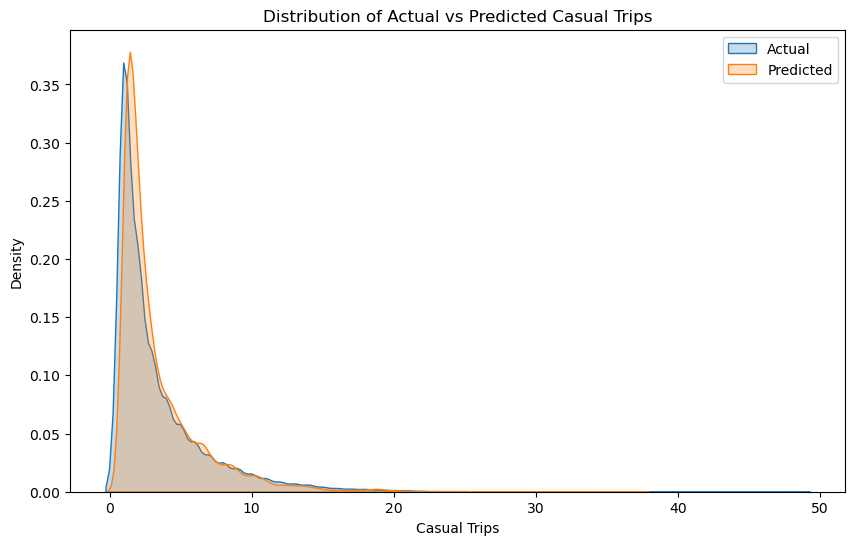

In [44]:
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual', fill=True)   # Replaced shade=True with fill=True
sns.kdeplot(y_pred, label='Predicted', fill=True)

plt.xlabel('Casual Trips')
plt.title('Distribution of Actual vs Predicted Casual Trips')
plt.legend()
plt.show()

In [47]:
# Assuming your dataframe is named bike_hourly_new
# Convert 'started_at' to datetime if it's not already
bike_master_clean_2023['started_at'] = pd.to_datetime(bike_master_clean_2023['started_at'])

# Sample 20% of data while maintaining rideable_type distribution
stratified_sample, _ = train_test_split(bike_master_clean_2023, test_size=0.8, stratify=bike_master_clean_2023['rideable_type'], random_state=42)

# Extract day and additional features
stratified_sample['day'] = stratified_sample['started_at'].dt.date
stratified_sample['day_of_week'] = stratified_sample['started_at'].dt.dayofweek
stratified_sample['month'] = stratified_sample['started_at'].dt.month

# Group by day, rideable_type, start_station_name, day_of_week, and month to get ride counts
grouped = (stratified_sample.groupby(['day', 'rideable_type', 'start_station_name', 'day_of_week', 'month'], observed=True)
             .size()
             .reset_index(name='ride_count'))

# Feature engineering
grouped['lag_1'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].shift(1)
grouped['lag_7'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].shift(7)
grouped['rolling_mean_7'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].transform(lambda x: x.rolling(window=7).mean())
grouped['is_weekend'] = grouped['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Drop NaN values
grouped.dropna(inplace=True)

# Define features and target
X = grouped[['day_of_week', 'month', 'lag_1', 'lag_7', 'rolling_mean_7', 'is_weekend']]
y = grouped['ride_count']

# Polynomial Features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Polynomial Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized Mean Squared Error (MSE) for Casual:", mse)
print(f"Optimized R^2 Score for Casual:", r2)

# Display Actual vs Predicted Values
comparison_df = pd.DataFrame({
    'Actual Casual Trips': y_test.values,
    'Predicted Casual Trips': y_pred
})

# Predict future trips
grouped['predicted_rides'] = model.predict(poly.transform(grouped[['day_of_week', 'month', 'lag_1', 'lag_7', 'rolling_mean_7', 'is_weekend']]))

# Get top 20 stations with the highest predicted rides
top_20_predicted = (grouped.sort_values(['day', 'rideable_type', 'predicted_rides'], ascending=[True, True, False])
                                .groupby(['day', 'rideable_type'], observed=True)
                                .head(20)
                                .reset_index(drop=True))

print(top_20_predicted.head())

Optimized Mean Squared Error (MSE) for Casual: 3.5759582336828757
Optimized R^2 Score for Casual: 0.7284456496475126
          day rideable_type               start_station_name  day_of_week  \
0  2023-01-08  classic_bike  Columbus Circle / Union Station            6   
1  2023-01-08  classic_bike      New Hampshire Ave & T St NW            6   
2  2023-01-08  classic_bike                   15th & P St NW            6   
3  2023-01-08  classic_bike                    5th & K St NW            6   
4  2023-01-08  classic_bike                   14th & V St NW            6   

   month  ride_count  lag_1  lag_7  rolling_mean_7  is_weekend  \
0      1          17   11.0    7.0       17.571429           1   
1      1          11   20.0   12.0       13.571429           1   
2      1          14   13.0    6.0       13.714286           1   
3      1          12    7.0    7.0       12.714286           1   
4      1           8   10.0   10.0       10.857143           1   

   predicted_rides  
0 